# Compare modeled neural activity before vs far from copulation time

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_plot, set_color
from my_torch import skl_fit_ridge
from my_stats import nanpearsonr

from record_0_main import smlt_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

ALPHA = 10

# Compute PCs of fast-adapt, slow-integrate ppln

In [2]:
# SPECIFY STRAINS USED
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

In [3]:
# record activity on the fly
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_trs = [df_behav[df_behav.ID == i] for i in ISTRAIN]
df_behav = None

In [4]:
N = 20

rtau_r = [120, 120]
rtau_a = [.1, 2]

tau_rs = np.random.uniform(*rtau_r, N)
tau_as = np.random.uniform(*rtau_a, N)
x_ss = np.random.uniform(0, 1, N)
x_ps = 1 - x_ss

params = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps}

In [5]:
songs = []
rs_20_mas = []

for df_tr in df_trs:
    t = np.array(df_tr['T'])
    
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    b = np.zeros(len(t), dtype=int)
    b[i_s == 1] = 1
    b[i_p == 1] = 2
    
    songs.append(b)

    # simulate population response
    rs_20_ma = smlt_ma(i_s, i_p, params, DT)
    sys.stdout.write('.')
    
    rs_20_mas.append(rs_20_ma)
    
rs_20_ma_all = cc(rs_20_mas, axis=0)

.......................................................................................

In [6]:
pca_20 = decomposition.PCA().fit(rs_20_ma_all)
var_exp_ma_20 = pca_20.explained_variance_ratio_

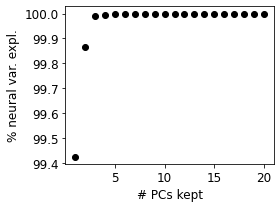

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
    
ax.scatter(np.arange(20)+1, 100*var_exp_ma_20.cumsum(), c='k')
set_plot(ax, x_label='# PCs kept', y_label='% neural var. expl.')

In [8]:
sesh_lens = np.array([len(song)*DT for song in songs])
iseshs_sorted = np.argsort(sesh_lens)

In [9]:
NPER = 30
labels = cc([np.repeat(1, NPER), np.repeat(0, NPER)])

# get shortest and longest sessions
song_shorts = []
song_longs = []

rs_shorts = []
rs_longs = []

for ishort, ilong in zip(iseshs_sorted[:NPER], iseshs_sorted[::-1][:NPER]):
    it_start_short = np.nonzero(songs[ishort])[0][0]
    
    song_short = songs[ishort][it_start_short:]
    rs_short = rs_20_mas[ishort][it_start_short:, :]
    
    song_shorts.append(song_short)
    rs_shorts.append(rs_short)
    
    # get matched session w no copulation
    it_start_long = np.nonzero(songs[ilong])[0][0]
    
    song_long = songs[ilong][it_start_long:it_start_long+len(song_short)]
    rs_long = rs_20_mas[ilong][it_start_long:it_start_long+len(song_short)]
    
    song_longs.append(song_long)
    rs_longs.append(rs_long)

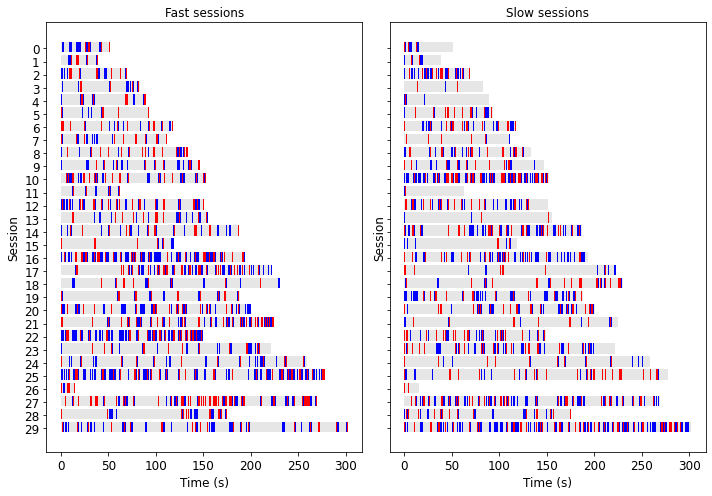

In [10]:
from disp import plot_b

fig, axs = plt.subplots(1, 2, figsize=(10, 7), sharey=True, tight_layout=True)

y_tick_labels = []
for cpair, (song_short, song_long) in enumerate(zip(song_shorts, song_longs)):
    plot_b(axs[0], np.arange(len(song_short))*DT, song_short, extent=[0, DT*len(song_short), -cpair, -cpair-.8], c=((.9, .9, .9), 'b', 'r'))
    plot_b(axs[1], np.arange(len(song_long))*DT, song_long, extent=[0, DT*len(song_short), -cpair, -cpair-.8], c=((.9, .9, .9), 'b', 'r'))
    y_tick_labels.append(cpair)
    
set_plot(axs[0], y_ticks=(-np.arange(len(song_shorts))-.5), y_tick_labels=y_tick_labels, x_label='Time (s)', y_label='Session', title='Fast sessions')
set_plot(axs[1], x_label='Time (s)', y_label='Session', title='Slow sessions')

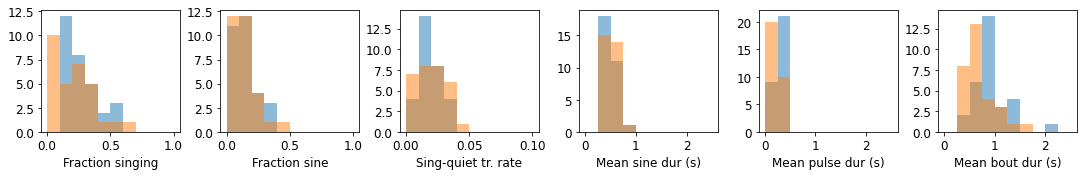

In [11]:
# heuristics
def get_mn_bout_dur(song):
    segs, bds = get_seg(song > 0, min_gap=1)
    return np.mean(bds[:, 1]- bds[:, 0])*DT

def get_song_q_trs(song):
    return np.mean(np.abs(np.diff(song > 0)))

def get_mn_sine_dur(song):
    segs, bds = get_seg(song==1, min_gap=1)
    return np.mean(bds[:, 1]- bds[:, 0])*DT

def get_mn_pulse_dur(song):
    segs, bds = get_seg(song==2, min_gap=1)
    return np.mean(bds[:, 1]- bds[:, 0])*DT


fig, axs = plt.subplots(1, 6, figsize=(15, 2.5), tight_layout=True)

feats_song = np.transpose([
    [np.mean(song > 0) for song in song_shorts] + [np.mean(song > 0) for song in song_longs],  # mean singing
    [np.mean(song == 1) for song in song_shorts] + [np.mean(song == 1) for song in song_longs],  # mean sine
    [get_song_q_trs(song) for song in song_shorts] + [get_song_q_trs(song) for song in song_longs],  # song-q tr rate
    [get_mn_sine_dur(song) for song in song_shorts] + [get_mn_sine_dur(song) for song in song_longs],  # mean sine dur
    [get_mn_pulse_dur(song) for song in song_shorts] + [get_mn_pulse_dur(song) for song in song_longs],  # mean sine dur
    [get_mn_bout_dur(song) for song in song_shorts] + [get_mn_bout_dur(song) for song in song_longs],  # mean bout dur
])

## mean singing
axs[0].hist(feats_song[labels==1, 0], bins=np.linspace(0, 1, 11), alpha=.5)
axs[0].hist(feats_song[labels==0, 0], bins=np.linspace(0, 1, 11), alpha=.5)
set_plot(axs[0], x_label='Fraction singing')

## mean sine
axs[1].hist(feats_song[labels==1, 1], bins=np.linspace(0, 1, 11), alpha=.5)
axs[1].hist(feats_song[labels==0, 1], bins=np.linspace(0, 1, 11), alpha=.5)
set_plot(axs[1], x_label='Fraction sine')

## singing-quiet transition rate
axs[2].hist(feats_song[labels==1, 2], bins=np.linspace(0, .1, 11), alpha=.5)
axs[2].hist(feats_song[labels==0, 2], bins=np.linspace(0, .1, 11), alpha=.5)
set_plot(axs[2], x_label='Sing-quiet tr. rate')

## mean sine segment duration
axs[3].hist(feats_song[labels==1, 3], bins=np.linspace(0, 2.5, 11), alpha=.5)
axs[3].hist(feats_song[labels==0, 3], bins=np.linspace(0, 2.5, 11), alpha=.5)
set_plot(axs[3], x_label='Mean sine dur (s)')

## mean pulse segment duration
axs[4].hist(feats_song[labels==1, 4], bins=np.linspace(0, 2.5, 11), alpha=.5)
axs[4].hist(feats_song[labels==0, 4], bins=np.linspace(0, 2.5, 11), alpha=.5)
set_plot(axs[4], x_label='Mean pulse dur (s)')

# bout duration
axs[5].hist(feats_song[labels==1, 5], bins=np.linspace(0, 2.5, 11), alpha=.5)
axs[5].hist(feats_song[labels==0, 5], bins=np.linspace(0, 2.5, 11), alpha=.5)
set_plot(axs[5], x_label='Mean bout dur (s)')

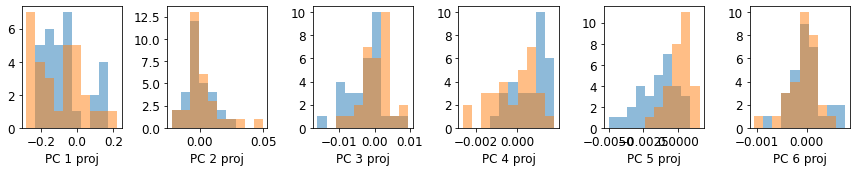

In [12]:
# model neural activity
rs_final_short = np.array([rs[-1, :] for rs in rs_shorts])
rs_final_long = np.array([rs[-1, :] for rs in rs_longs])

feats_r = cc([pca_20.transform(rs_final_short), pca_20.transform(rs_final_long)])

fig, axs = plt.subplots(1, 6, figsize=(12, 2.5), tight_layout=True)

for cpc, ax in enumerate(axs):
    x_short = feats_r[labels==1, cpc]
    x_long = feats_r[labels==0, cpc]
    
    x_min = np.min([x_short.min(), x_long.min()])
    x_max = np.max([x_short.max(), x_long.max()])
    bins = np.linspace(x_min, x_max, 11)
    ax.hist(x_short, bins=bins, alpha=.5)
    ax.hist(x_long, bins=bins, alpha=.5)
    
    set_plot(ax, x_label=f'PC {cpc+1} proj')

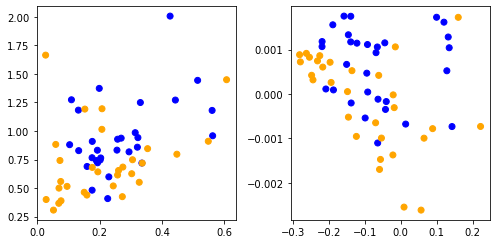

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), tight_layout=True)
axs[0].scatter(feats_song[:, 0], feats_song[:, -1], c=np.array(['orange', 'b'])[labels])
axs[1].scatter(feats_r[:, 0], feats_r[:, 3], c=np.array(['orange', 'b'])[labels])

In [14]:
feats_song_normed = feats_song / feats_song.std(0)
feats_r_normed = feats_r / feats_r.std(0)

In [15]:
def get_clf_acc(xs, y, c):
    rgr = LogisticRegression(C=c).fit(xs, y)
    y_hat = rgr.predict(xs)
    return np.mean(y==y_hat)

def get_k_fold_clf_acc(xs, y, c):
    rgr = LogisticRegression(C=c)
    k = len(xs)//2
    
    accs = []
    
    for i in range(k):
        mtest = np.array([j in (i, i+k) for j in range(len(y))])
        mtrain = ~mtest
        rgr.fit(xs[mtrain], y[mtrain])
        y_hat_test = rgr.predict(xs[mtest])
        accs.append(np.mean(y[mtest]==y_hat_test))
        
    return accs

In [16]:
cs = np.logspace(-1, 2, 9, base=10)

acc_songs = []
acc_rs = []

for c in cs:
    acc_songs.append(get_clf_acc(feats_song_normed, labels, c=c))
    acc_rs.append(get_clf_acc(feats_r_normed[:, :5], labels, c=c))

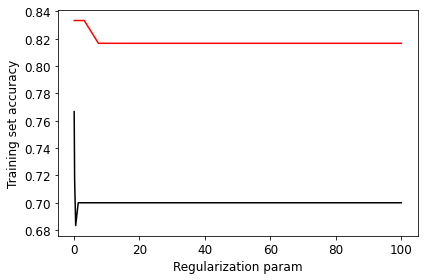

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax.plot(cs, acc_songs, c='k')
ax.plot(cs, acc_rs, c='r')

set_plot(ax, x_label='Regularization param', y_label='Training set accuracy')

C = 0.01
P = 0.006107038213626183
P = 0.025241199579382166
P = 0.03639560755691635
P = 0.681112524735338
P = 0.3050375839868198
P = 0.3050375839868198
P = 0.3050375839868198
P = 0.3050375839868198
P = 0.4316746107777446
C = 0.1
P = 0.003988085251316985
P = 0.019225128274589446
P = 0.028147050245247246
P = 0.6669481126884875
P = 0.11179774330320218
P = 0.1966767688875145
P = 0.3905514875564603
P = 0.3905514875564603
P = 0.681112524735338
C = 1.0
P = 0.01258035470096442
P = 0.05052168589645623
P = 0.19378051508248945
P = 0.384386576046042
P = 0.03943145287789914
P = 0.08288264411986124
P = 0.2781775493828095
P = 0.384386576046042
P = 0.2781775493828095
C = 10.0
P = 0.01258035470096442
P = 0.05052168589645623
P = 0.19378051508248945
P = 0.384386576046042
P = 0.06783964492506774
P = 0.08288264411986124
P = 0.5125060093207409
P = 0.5125060093207409
P = 0.5125060093207409
C = 100.0
P = 0.01258035470096442
P = 0.05052168589645623
P = 0.19378051508248945
P = 0.384386576046042
P = 0.06783964492

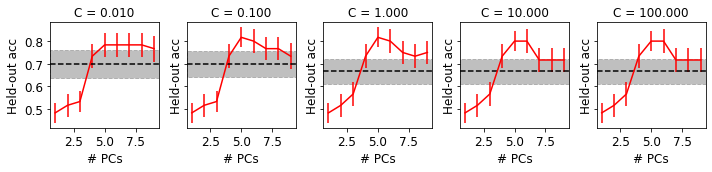

In [18]:
NPCS = np.arange(1, 10)
cs = np.logspace(-2, 2, 5, base=10)
fig, axs = plt.subplots(1, len(cs), figsize=(10, 2.5), sharey=True, tight_layout=True)

for c, ax in zip(cs, axs):
    print(f'C = {c}')

    acc_song = get_k_fold_clf_acc(feats_song_normed, labels, c=c)
    ax.axhline(np.mean(acc_song), c='k', ls='--')
    ax.axhspan(
        np.mean(acc_song) - stats.sem(acc_song),
        np.mean(acc_song) + stats.sem(acc_song),
        color='gray', alpha=.5, ls='--')

    mn_acc_rs = []
    sem_acc_rs = []
    for npc in NPCS:
        acc_rs = get_k_fold_clf_acc(feats_r_normed[:, :npc], labels, c=c)
        mn_acc_rs.append(np.mean(acc_rs))
        sem_acc_rs.append(stats.sem(acc_rs))
        print('P =', stats.ttest_ind(acc_song, acc_rs)[1])
        
    ax.errorbar(NPCS, mn_acc_rs, yerr=sem_acc_rs, c='r')
    
    set_plot(ax, x_label='# PCs', y_label='Held-out acc', title=f'C = {c:.3f}')

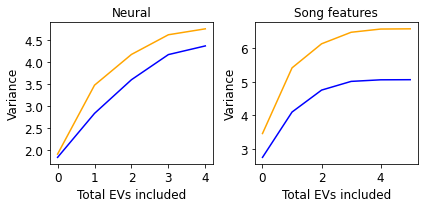

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
cov_r_short = np.cov(feats_r_normed[labels==1, :5].T)
evs_r_short = np.sort(np.abs(np.linalg.eig(cov_r_short)[0]))[::-1]

axs[0].plot(evs_r_short.cumsum(), c='b')

cov_r_long = np.cov(feats_r_normed[labels==0, :5].T)
evs_r_long = np.sort(np.abs(np.linalg.eig(cov_r_long)[0]))[::-1]

axs[0].plot(evs_r_long.cumsum(), c='orange')
set_plot(axs[0], x_label='Total EVs included', y_label='Variance', title='Neural')

cov_song_short = np.cov(feats_song_normed[labels==1].T)
evs_song_short = np.sort(np.abs(np.linalg.eig(cov_song_short)[0]))[::-1]

axs[1].plot(evs_song_short.cumsum(), c='b')

cov_song_long = np.cov(feats_song_normed[labels==0].T)
evs_song_long = np.sort(np.abs(np.linalg.eig(cov_song_long)[0]))[::-1]

axs[1].plot(evs_song_long.cumsum(), c='orange')
set_plot(axs[1], x_label='Total EVs included', y_label='Variance', title='Song features')